In [1]:
N_SAMPLE = 10000

In [2]:
import pandas as pd

# https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b

import matplotlib.pyplot as plt
import torch
import numpy as np
import random 
import spacy
import os
import sys
# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
from sklearn.model_selection import train_test_split

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from datetime import datetime
startTime = datetime.now()

# Load the local code
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.read_parallel import read_parallel_local

In [3]:
train_test_ratio = 0.10
train_valid_ratio = 0.80
first_n_words = 512

#nlp = spacy.load("en_core_web_sm", disable = ['ner', 'tagger', 'parser', 'textcat'])
#nlp.max_length = 10000000

#df_ml = pd.read_csv("temp_vn.csv", encoding="latin1", parse_dates=True)
#df_ml = df_ml[df_ml.len != -1]
#df_ml = df_ml[~df_ml.id.isna()]
#df_ml.id = df_ml.id.astype(int)
#df_ml = df_ml.sample(n=N_SAMPLE)  # random subsample to get going quicker
#df_ml['text'] = "zzz"
#df_ml = df_ml.reset_index(drop=True)

In [4]:
REDUCE_BY_FACTOR = 20.0 # Make the dataset smaller for development purposes

if 'DATA_VOL' not in os.environ:
    # Manually set:
    DATA_VOL = '/home/luke/tmp_vol'
else:
    DATA_VOL = os.environ['DATA_VOL']
    
# Pre-wrangled metadata
df = pd.read_csv("../references/derived/ml_data.csv", encoding="latin1", parse_dates=True)
df.id = df.id.astype(int)    
print(f"Original number of examples: {len(df)}")
df = df.sample(n=int(len(df)/REDUCE_BY_FACTOR)) #
print(f"Reduced number of examples:  {len(df)}")

df['text'] = read_parallel_local(df['id'], DATA_VOL + "/clean/")

df = df.reset_index(drop=True)

Original number of examples: 199451
Reduced number of examples:  9972
Took 0.8421096086502076 min to open 9972 files with 20 processes.


In [5]:
df_ml = df

In [6]:
def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x
    
#    tokens = nlp(d1)
#    str_tokens = [token.orth_ for token in tokens[:512]]
#    df_ml.at[i, 'text'] = " ".join(str_tokens)
#    return(1)
    
startTime2 = datetime.now()
for i in range(len(df_ml)):
    df_ml.at[i, 'text'] = trim_string(df_ml.at[i, 'text'])
print(datetime.now()-startTime2)

# 43 min to process all the datafiles

0:00:00.301609


In [7]:
df_ml.head()

,bill_id,version_number,id,partisan_lean,sc_id,signed,text
0,1241311,2,2425753,0.538639,587-2,0,i 116th congress 1st session to direct the sec...
1,1125114,1,2161662,0.325274,600-1,0,mississippi legislature regular session to: ru...
2,1318520,1,2588301,0.350000,610-2,0,"hb 275: ""an act relating to penalties for moto..."
3,1304520,1,2545237,0.157102,639-2,0,20lso-0134 state of wyoming house bill no. hb0...
4,1320840,1,2575137,0.873694,635-2,0,h 7729state of rhode island in general assembl...


In [8]:
import pandas as pd

In [9]:
df_bert = df_ml[['signed', 'text']]
df_bert.head()

,signed,text
0,0,i 116th congress 1st session to direct the sec...
1,0,mississippi legislature regular session to: ru...
2,0,"hb 275: ""an act relating to penalties for moto..."
3,0,20lso-0134 state of wyoming house bill no. hb0...
4,0,h 7729state of rhode island in general assembl...


In [10]:
destination_folder = 'bert_classification'

# Train-test split
df_train_full, df_test = train_test_split(df_bert, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_train, df_valid = train_test_split(df_train_full, train_size = train_valid_ratio, random_state = 1)

# Write preprocessed data
df_train.to_csv(destination_folder + '/train.csv', index=False)
df_valid.to_csv(destination_folder + '/valid.csv', index=False)
df_test.to_csv(destination_folder + '/test.csv', index=False)

In [11]:
# Preprocess and prepare

device = "cuda"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = first_n_words
NUM_EPOCHS = 20
BATCH_SIZE = 4
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field), ('text', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=destination_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

/home/luke/repos/govhawk_ml/env/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/luke/repos/govhawk_ml/env/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/luke/repos/govhawk_ml/env/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please se

TypeError: 'function' object is not subscriptable

In [12]:
test_iter

In [13]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [22]:
BERT().encoder

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [29]:
class BERT_custom(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.bert_model = BertModel.from_pretrained(options_name)
        self.fc1 = torch.nn.Linear(770, 770)
        self.fc2 = torch.nn.Linear(770, 2)

    def forward(self, text, partisan_lean, revision_number, label):
        
        h = self.bert(text)
        h_new = torch.cat(partisan_lean, revision_number, h)
        dense1 = torch.nn.relu(self.fc1(h_new))
        y_pred = torch.nn.Softmax(self.fc2(dense1), dim=1)
        
        return y_pred

In [25]:
from transformers import BertModel

In [28]:
BertModel.from_pretrained("bert-base-uncased")

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [14]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [33]:
for (label, text), _ in train_iter:
    print(label)
    print(text)

TypeError: 'BucketIterator' object is not subscriptable

In [16]:
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = NUM_EPOCHS,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, text), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, text), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/20], Step [100/4000], Train Loss: 0.4506, Valid Loss: 0.5224
Model saved to ==> bert_classification/model.pt
Model saved to ==> bert_classification/metrics.pt
Epoch [1/20], Step [200/4000], Train Loss: 0.3860, Valid Loss: 0.6524
Epoch [2/20], Step [300/4000], Train Loss: 0.4529, Valid Loss: 0.5051
Model saved to ==> bert_classification/model.pt
Model saved to ==> bert_classification/metrics.pt
Epoch [2/20], Step [400/4000], Train Loss: 0.3806, Valid Loss: 0.6375
Epoch [3/20], Step [500/4000], Train Loss: 0.4471, Valid Loss: 0.4890
Model saved to ==> bert_classification/model.pt
Model saved to ==> bert_classification/metrics.pt
Epoch [3/20], Step [600/4000], Train Loss: 0.3337, Valid Loss: 0.6113
Epoch [4/20], Step [700/4000], Train Loss: 0.4306, Valid Loss: 0.4763
Model saved to ==> bert_classification/model.pt
Model saved to ==> bert_classification/metrics.pt
Epoch [4/20], Step [800/4000], Train Loss: 0.2971, Valid Loss: 0.5836
Epoch [5/20], Step [900/4000], Train Loss: 0.384

KeyboardInterrupt: 

In [15]:
#train(model=model, optimizer=optimizer)
print(torch.__version__)

1.7.1


Model loaded from <== bert_classification/metrics.pt


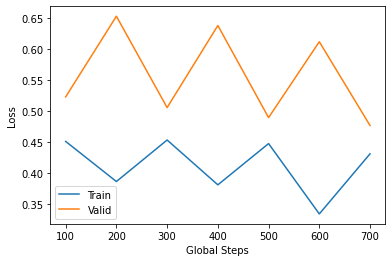

In [17]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== bert_classification/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000      1236
           0     0.8623    1.0000    0.9261      7739

    accuracy                         0.8623      8975
   macro avg     0.4311    0.5000    0.4630      8975
weighted avg     0.7435    0.8623    0.7985      8975



/home/luke/repos/govhawk_ml/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


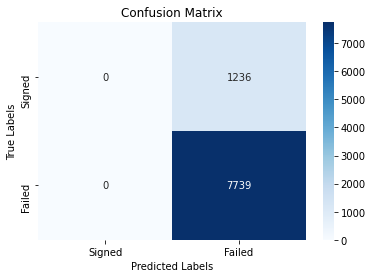

In [18]:

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, text), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Signed', 'Failed'])
    ax.yaxis.set_ticklabels(['Signed', 'Failed'])
    
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)

In [19]:
(5966+723)/(5966+723+638+1673)

0.7432222222222222

In [ ]:
# 10000 samples, 5 epochs, 128 seq_len:  accuracy = 0.743
# 100,000 samples, 5 epochs, 128 seq_len: accuracy = 0.818
# 10,000 samples, 5 epochs, 512 seq_len, accuracy = 0.747
# 10,000 samples, 5 epochs, 512 seq len, accuracy = 0.687
print(datetime.now() - startTime)
print("sequence length:{}, N samples:{}, time:{}".format(MAX_SEQ_LEN, N_SAMPLE, datetime.now() - startTime)